In [1]:
import soundfile
import numpy as np
import librosa
import glob
import os
from sklearn.model_selection import train_test_split

# All emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}

In [2]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")

    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [3]:
# def load_data(test_size=0.2):
test_size=0.25
X, y = [], []
for file in glob.glob("data/Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # extract speech features
    features = extract_feature(file, mfcc=True, chroma=True, mel=True)
    # add to data
    X.append(features)
    y.append(emotion)
# split the data to training and testing and return it
train_test_split(np.array(X), y, test_size=test_size, random_state=7)

[array([[-6.75650085e+02,  9.21675873e+01,  6.17219257e+00, ...,
          2.09085715e-06,  1.41443979e-06,  1.10900953e-06],
        [-4.56590485e+02,  2.38685207e+01, -2.35430698e+01, ...,
          1.96467474e-04,  1.00394347e-04,  6.93314360e-05],
        [-5.27341187e+02,  2.21599789e+01, -1.56013918e+01, ...,
          2.31548489e-04,  1.72219283e-04,  9.68881068e-05],
        ...,
        [-3.57380066e+02,  1.34679565e+01, -1.66995087e+01, ...,
          3.10279801e-03,  1.93412637e-03,  1.57549290e-03],
        [-6.76129761e+02,  6.07729759e+01,  8.59902000e+00, ...,
          1.32644539e-06,  1.24813118e-06,  8.28826273e-07],
        [-5.95663818e+02,  6.33558578e+01, -9.15794277e+00, ...,
          6.76750278e-05,  3.17838239e-05,  1.83957854e-05]]),
 array([[-5.72498230e+02,  4.91992531e+01,  5.40661860e+00, ...,
          3.17447761e-04,  3.27895832e-04,  2.04258919e-04],
        [-5.14230225e+02,  5.16041489e+01, -1.68846893e+01, ...,
          2.26257616e-04,  1.99596383e

In [4]:
def load_data(test_size=0.25):
    X, y = [], []
    for file in glob.glob("data/Actor_*/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True, chroma=True, mel=True)
        # add to data
        X.append(features)
        y.append(emotion)
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=10)

### MLP Classifer Model

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
# from utils import load_data
import os
import pickle

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
# load RAVDESS dataset
X_train, X_test, y_train, y_test = load_data(test_size=0.30)
# Number of Samples in training data

print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])

# Number of features used this is a vector of features extracted
# Using utils.extract_features() method

print("[+] Number of features:", X_train.shape[1])
# best model, determined by a grid search
model_params = {
    'alpha': 0.01,
    'batch_size': 128,
    'epsilon': 1e-08,
    'hidden_layer_sizes': (300,),
    'learning_rate': 'adaptive',
    'max_iter': 500,
}

[+] Number of training samples: 294
[+] Number of testing samples: 126
[+] Number of features: 180


[*] Training the model...
Accuracy: 72.22%


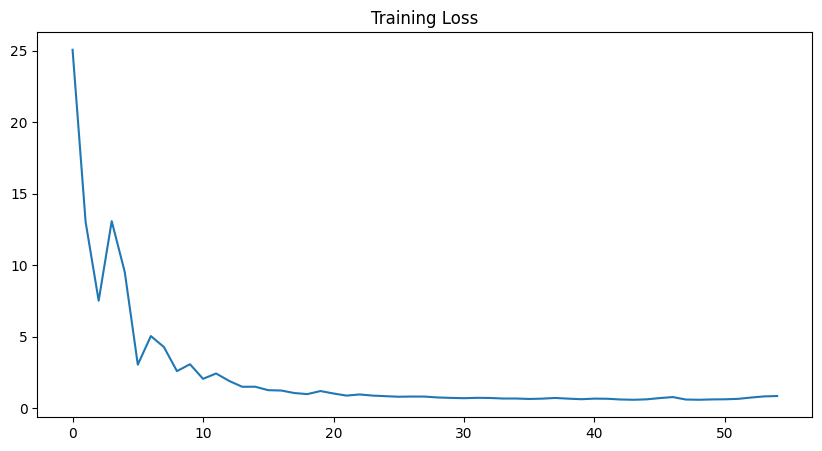

In [8]:
# Initialize Multi Layer Perceptron classifier with Best Parameters
model = MLPClassifier(**model_params)

# Train the model and capture the training history
print("[*] Training the model...")
history = model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy on the test set
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.loss_curve_)
plt.title("Training Loss")

plt.show()

In [9]:
# Saving the Model
# Make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(model, open("result/mlp_classifier2model.h5", "wb"))

## SVM Model Classification

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load and split the data (as you did before)
X_train, X_test, y_train, y_test = load_data(test_size=0.30)

# Number of Samples in training data
print("[+] Number of training samples:", X_train.shape[0])

# Number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])

# Number of features used this is a vector of features extracted
# Using utils.extract_features() method
print("[+] Number of features:", X_train.shape[1])

# Initialize the SVM classifier with parameters
svm_params = {
    'C': 1.0,
    'kernel': 'linear',  # You can explore different kernels
    'random_state': 10,
}

[+] Number of training samples: 294
[+] Number of testing samples: 126
[+] Number of features: 180


In [11]:
model2 = SVC(**svm_params)

# Train the SVM model
print("[*] Training the SVM model...")
model2.fit(X_train, y_train)

# Predict on the test set
y_pred = model2.predict(X_test)

# Calculate the accuracy on the test set
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

[*] Training the SVM model...
Accuracy: 72.22%


In [12]:
# Saving the Model
# Make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(model2, open("result/svm_audioClassify.h5", "wb"))

## Splitting Data

In [13]:
baseline = "03-01-04-02-02-01-18.wav"
em=baseline.split("-")[2]
emotion = int2emotion[baseline.split("-")[2]]
print(em)
print(emotion)

04
sad


In [15]:
RATE = 16000
from scipy.io import wavfile
import noisereduce as nr
# load data
#Actor 15 Second File
rate, data = wavfile.read("result/03-01-01-01-01-02-15.wav")
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=RATE, prop_decrease=0.65,n_std_thresh_stationary=1.8)
wavfile.write("result/myred_noise.wav", rate, reduced_noise)

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [17]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True